<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/doc2vec_chip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import re
import time
import tensorflow as tf
from tensorflow import keras

In [3]:
!pip install biopython
from Bio import SeqIO

     |████████████████████████████████| 2.3MB 2.7MB/s 


# Read Data

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':"1Tu87YTnQ7IJ7nOoK1NvyNj3khhDDF0Jk"})
downloaded.GetContentFile('train.fasta', mimetype=None)  
downloaded = drive.CreateFile({'id':"1kb8niGWPBlzvoQkpEcXv6Q_ZssPwbMkA"})
downloaded.GetContentFile('valid.fasta', mimetype=None)  
downloaded = drive.CreateFile({'id':"1TzGDxynuWXYEsVFOd5bGsKU0Gbh3m4aT"})
downloaded.GetContentFile('test.fasta', mimetype=None)  

In [6]:
def readFasta(file):
  with open(file, 'r') as f:
    records = np.array([record.seq._data.upper() for record in SeqIO.parse(f, 'fasta')])
  with open(file, 'r') as f:
    records_id = np.array([record.id for record in SeqIO.parse(f, 'fasta')])
  print('reading', str(file), 'Number of sequences :', 
        len(records), 'Length of sequences :', len(records[0]))
  records_df = pd.DataFrame({'id': records_id, 'seq': records})
  return records_df

In [7]:
# read fasta data
chip_train = readFasta('train.fasta')
chip_val = readFasta('valid.fasta')
chip_test = readFasta('test.fasta')
chip_train["id"] = chip_train["id"].astype(int)
chip_val["id"] = chip_val["id"].astype(int)
chip_test["id"] = chip_test["id"].astype(int)
print(chip_train.id.value_counts())
print(chip_val.id.value_counts())
print(chip_test.id.value_counts())

reading train.fasta Number of sequences : 77174 Length of sequences : 101
reading valid.fasta Number of sequences : 1000 Length of sequences : 101
reading test.fasta Number of sequences : 19544 Length of sequences : 101
1    38638
0    38536
Name: id, dtype: int64
1    500
0    500
Name: id, dtype: int64
0    9823
1    9721
Name: id, dtype: int64


In [ ]:
# splice_df.columns = ['Classes', 'Name', 'Seq']
# splice_df.Seq = splice_df.Seq.str.replace(' ', '').replace('D', 'N').replace('S', 'N').replace('R', 'N')
# splice_df.Classes.value_counts()

In [ ]:
# splice_df["Label"] = splice_df.apply(lambda row: convert_label(row), axis=1)
# splice_df.head()

In [8]:
def n_gram(x, word_size=3):
  arr_x = [c for c in x]
  words = tf.strings.ngrams(arr_x, ngram_width=word_size, separator='').numpy()
  words = list(pd.Series(words).apply(lambda b: b.decode('utf-8')))
  return words

In [9]:
chip_train["ngram"] = chip_train.seq.apply(n_gram)
chip_train.head()

,id,seq,ngram
0,1,GTGATCACAGTAGTTTTGTGTCCACAGTAACACACAAATCAGTCTC...,"[GTG, TGA, GAT, ATC, TCA, CAC, ACA, CAG, AGT, ..."
1,1,CATCTAGGCCAGGGGTAGCACAAGCGCCTGAGAGAGCTGGAGCCGC...,"[CAT, ATC, TCT, CTA, TAG, AGG, GGC, GCC, CCA, ..."
2,0,CAGGATAGAGGATTGATTAGGGTAGTTGCTCTCAATTTTGCCCCCC...,"[CAG, AGG, GGA, GAT, ATA, TAG, AGA, GAG, AGG, ..."
3,0,CCCTGGCCCAATACCCAACAGAAACCTAGTCAAATACCCATGATCT...,"[CCC, CCT, CTG, TGG, GGC, GCC, CCC, CCA, CAA, ..."
4,0,GACACTAGGTGGTTTAAATTTGCTGAAATGTCTCCATCTGGTGGAC...,"[GAC, ACA, CAC, ACT, CTA, TAG, AGG, GGT, GTG, ..."


In [10]:
chip_val["ngram"] = chip_val.seq.apply(n_gram)
chip_val.head()

,id,seq,ngram
0,0,CATTGCAGTTCGTCTTAGCGCCGCCAGGCATGGTGTCCTGCATCAC...,"[CAT, ATT, TTG, TGC, GCA, CAG, AGT, GTT, TTC, ..."
1,1,GGCCTGAGCTGCACAGGGGCCTGCTCAAATTTCTCCACTGGGCAGC...,"[GGC, GCC, CCT, CTG, TGA, GAG, AGC, GCT, CTG, ..."
2,1,ACTCTTTTGCTGGTGTTTCCCCGGTATCACACGTAGCCCTGCTTCC...,"[ACT, CTC, TCT, CTT, TTT, TTT, TTG, TGC, GCT, ..."
3,0,GTCAGGATAAACTAGTGCACAAACAGCCAAATTACCACTAGGGGGC...,"[GTC, TCA, CAG, AGG, GGA, GAT, ATA, TAA, AAA, ..."
4,0,GATGGTGACTGGCTCCATCTGGGGGCGGGAGGGTCGGCCGTGGGTC...,"[GAT, ATG, TGG, GGT, GTG, TGA, GAC, ACT, CTG, ..."


In [11]:
chip_test["ngram"] = chip_test.seq.apply(n_gram)
chip_test.head()

,id,seq,ngram
0,0,AACTGATATGGCCATCACTGTGAAGAGCTGGGTACACACATCAGCC...,"[AAC, ACT, CTG, TGA, GAT, ATA, TAT, ATG, TGG, ..."
1,0,TTCTCGTGTGCTGGGATCCATATAGAAGGAGATGGGCTCCACCGTC...,"[TTC, TCT, CTC, TCG, CGT, GTG, TGT, GTG, TGC, ..."
2,0,GCAGCTGCTCCATGGTCTCATACATGCCTTGGCAGGAGCGCAGCTT...,"[GCA, CAG, AGC, GCT, CTG, TGC, GCT, CTC, TCC, ..."
3,0,TGAATGAGGTAGACATGAAGGAATCCTCAAGTTGAGTGCACATCTC...,"[TGA, GAA, AAT, ATG, TGA, GAG, AGG, GGT, GTA, ..."
4,0,AGTTCTTAGACCCGCGTGCAGATCCGGCCGCGACACAGGCGAGACC...,"[AGT, GTT, TTC, TCT, CTT, TTA, TAG, AGA, GAC, ..."


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
# xtrain, xtest, ytrain, ytest = train_test_split(splice_df, splice_df.Label, test_size=0.2, random_state=100, stratify=splice_df.Label)
# xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

In [13]:
word_size = 3
# vocab = [''.join(c) for c in product('ATCGN', repeat=word_size)]

In [14]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
xtrain_tagged = chip_train.apply(
    lambda r: TaggedDocument(words=r["ngram"], tags=[r["id"]]), axis=1
)
xval_tagged = chip_val.apply(
    lambda r: TaggedDocument(words=r["ngram"], tags=[r["id"]]), axis=1
)
xtest_tagged = chip_test.apply(
    lambda r: TaggedDocument(words=r["ngram"], tags=[r["id"]]), axis=1
)

In [15]:
import multiprocessing
from tqdm import tqdm
import time
tqdm.pandas(desc="progress-bar")

cores = multiprocessing.cpu_count()
cores

2

In [ ]:
# def doc2vec_training_test(embed_size_list=[30], figsize=(15,4), verbose=0):
#   num_model = len(embed_size_list)
#   fig, axes = plt.subplots(num_model, 3, figsize=figsize)
#   model_list = []
#   hist_list = []
#   es_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
#   ytrain = chip_train["id"][:100]
#   yval = chip_val["id"][:100]
#   # ytest = chip_test["id"][:100]
#   for embed_size in embed_size_list:
#     start = time.time()
#     print("training doc2vec for embedding size =", embed_size)
#     model_dm = Doc2Vec(dm=1, vector_size=embed_size, negative=5, hs=0, \
#                       min_count=2, sample=0, workers=cores)
#     if verbose == 1:
#       model_dm.build_vocab([x for x in tqdm(xtrain_tagged.values[:100])])
#     else:
#       model_dm.build_vocab(xtrain_tagged.values[:100])

#     for epoch in range(10):
#       if verbose == 1:
#         model_dm.train([x for x in tqdm(xtrain_tagged.values[:100])], \
#               total_examples=len(xtrain_tagged.values[:100]), epochs=1)
#       else:
#         model_dm.train(xtrain_tagged.values, \
#               total_examples=len(xtrain_tagged.values[:100]), epochs=1)
#       model_dm.alpha -= 0.002 
#       model_dm.min_alpha = model_dm.alpha
#     xtrain_vec = getVec(model_dm, xtrain_tagged[:100])
#     xval_vec = getVec(model_dm, xval_tagged[:100])
#     # xtest_vec = getVec(model_dm, xtest_tagged[:100])
#     print("the shape for training vector is", xtrain_vec.shape)
#     xtrain_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtrain_vec)
#     xval_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xval_vec)
#     # xtest_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtest_vec)
#     plotVec(axes[0], xtrain_tsne, ytrain, title="TSNE, training, embedding="+str(embed_size))
#     plotVec(axes[1], xval_tsne, yval, title="TSNE, validation, embedding="+str(embed_size))
#     # plotVec(axes[counter, 2], xtest_tsne, ytest, title="TSNE, test, embedding="+str(embed_size))

#     print("training NN for embedding size =", embed_size)
#     model = keras.Sequential([
#       keras.layers.Dense(128, activation="relu", input_shape=[embed_size]),
#       keras.layers.Dropout(0.2),
#       keras.layers.Dense(64, activation="relu"),       
#       keras.layers.Dense(32, activation="relu"),       
#       keras.layers.Dense(16, activation="relu"),       
#       keras.layers.Dense(1, activation="sigmoid")                        
#     ])
#     model.compile(keras.optimizers.SGD(momentum=0.9), \
#           keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
    
#     hist = model.fit(xtrain_vec, ytrain, \
#           validation_data=(xval_vec, yval), 
#           epochs=30, callbacks=[es_cb])
#     train_loss, train_acc = model.evaluate(xtrain_vec, ytrain)
#     val_loss, val_acc = model.evaluate(xval_vec, yval)
#     # test_loss, test_acc = model.evaluate(xtest_vec, ytest)
#     print("Evaluation on training set: loss", np.round(train_loss, 3), \
#           "accuracy", np.round(train_acc, 3))
#     print("Evaluation on validation set: loss", np.round(val_loss, 3), \
#           "accuracy", np.round(val_acc, 3))
#     # print("Evaluation on test set: loss", np.round(test_loss, 3), \
#           # "accuracy", np.round(test_acc, 3))
#     model_list.append(model)
#     hist_list.append(hist)
#     end = time.time()
#     print("running time in ", end - start, "seconds")
#     print("\n\n")
  
#   return model_list, hist_list

In [ ]:
# doc2vec_training_test()

In [16]:
def getVec(model, tagged_docs, epochs=20):
  sents = tagged_docs.values
  regressors = [model.infer_vector(doc.words, epochs=epochs) for doc in sents]
  return np.array(regressors)

def plotVec(ax, x, y, title="title"):
  scatter = ax.scatter(x[:, 0], x[:, 1], c=y, 
             cmap=matplotlib.colors.ListedColormap(["red", "blue", "yellow"]))
  ax.set_title(title)
  ax.legend(*scatter.legend_elements(), loc=0, title="Classes")

def doc2vec_training(embed_size_list=[30,50,60,80], figsize=(15,20), verbose=0):
  num_model = len(embed_size_list)
  fig, axes = plt.subplots(num_model, 3, figsize=figsize)
  counter = 0
  model_list = []
  hist_list = []
  es_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
  ytrain = chip_train["id"]
  yval = chip_val["id"]
  ytest = chip_test["id"]
  for embed_size in embed_size_list:
    start = time.time()
    print("training doc2vec for embedding size =", embed_size)
    model_dm = Doc2Vec(dm=1, vector_size=embed_size, negative=5, hs=0, \
                      min_count=2, sample=0, workers=cores)
    if verbose == 1:
      model_dm.build_vocab([x for x in tqdm(xtrain_tagged.values)])
    else:
      model_dm.build_vocab(xtrain_tagged.values)

    for epoch in range(80):
      if verbose == 1:
        model_dm.train([x for x in tqdm(xtrain_tagged.values)], \
              total_examples=len(xtrain_tagged.values), epochs=1)
      else:
        model_dm.train(xtrain_tagged.values, \
              total_examples=len(xtrain_tagged.values), epochs=1)
      model_dm.alpha -= 0.002 
      model_dm.min_alpha = model_dm.alpha
    xtrain_vec = getVec(model_dm, xtrain_tagged)
    xval_vec = getVec(model_dm, xval_tagged)
    xtest_vec = getVec(model_dm, xtest_tagged)
    print("the shape for training vector is", xtrain_vec.shape, \
      "the shape for test vector is", xtest_vec.shape)
    xtrain_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtrain_vec)
    xval_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xval_vec)
    xtest_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtest_vec)
    plotVec(axes[counter, 0], xtrain_tsne, ytrain, title="TSNE, training, embedding="+str(embed_size))
    plotVec(axes[counter, 1], xval_tsne, yval, title="TSNE, validation, embedding="+str(embed_size))
    plotVec(axes[counter, 2], xtest_tsne, ytest, title="TSNE, test, embedding="+str(embed_size))
    counter += 1

    print("training NN for embedding size =", embed_size)
    model = keras.Sequential([
      keras.layers.Dense(128, activation="relu", input_shape=[embed_size]),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(64, activation="relu"),    
      keras.layers.Dropout(0.2),   
      keras.layers.Dense(32, activation="relu"),    
      keras.layers.Dropout(0.2),   
      keras.layers.Dense(16, activation="relu"),       
      keras.layers.Dense(1, activation="sigmoid")                        
    ])
    model.compile(keras.optimizers.SGD(momentum=0.9), \
          keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
    
    hist = model.fit(xtrain_vec, ytrain, \
          validation_data=(xval_vec, yval), 
          epochs=30, callbacks=[es_cb])
    train_loss, train_acc = model.evaluate(xtrain_vec, ytrain)
    val_loss, val_acc = model.evaluate(xval_vec, yval)
    test_loss, test_acc = model.evaluate(xtest_vec, ytest)
    print("Evaluation on training set: loss", np.round(train_loss, 3), \
          "accuracy", np.round(train_acc, 3))
    print("Evaluation on validation set: loss", np.round(val_loss, 3), \
          "accuracy", np.round(val_acc, 3))
    print("Evaluation on test set: loss", np.round(test_loss, 3), \
          "accuracy", np.round(test_acc, 3))
    model_list.append(model)
    hist_list.append(hist)
    end = time.time()
    print("running time in ", end - start, "seconds")
    print("\n\n")
  
  return model_list, hist_list

training doc2vec for embedding size = 30
the shape for training vector is (77174, 30) the shape for test vector is (19544, 30)
training NN for embedding size = 30
Epoch 1/30
2412/2412 [==============================] - 3s 1ms/step - loss: 0.6953 - accuracy: 0.5030 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/30
2412/2412 [==============================] - 3s 1ms/step - loss: 0.6926 - accuracy: 0.5112 - val_loss: 0.6926 - val_accuracy: 0.5150
Epoch 3/30
2412/2412 [==============================] - 3s 1ms/step - loss: 0.6923 - accuracy: 0.5122 - val_loss: 0.6919 - val_accuracy: 0.5140
Epoch 4/30
2412/2412 [==============================] - 3s 1ms/step - loss: 0.6921 - accuracy: 0.5139 - val_loss: 0.6919 - val_accuracy: 0.5150
Epoch 5/30
2412/2412 [==============================] - 3s 1ms/step - loss: 0.6919 - accuracy: 0.5135 - val_loss: 0.6916 - val_accuracy: 0.5180
Epoch 6/30
2412/2412 [==============================] - 3s 1ms/step - loss: 0.6917 - accuracy: 0.5182 - val_loss: 0.6

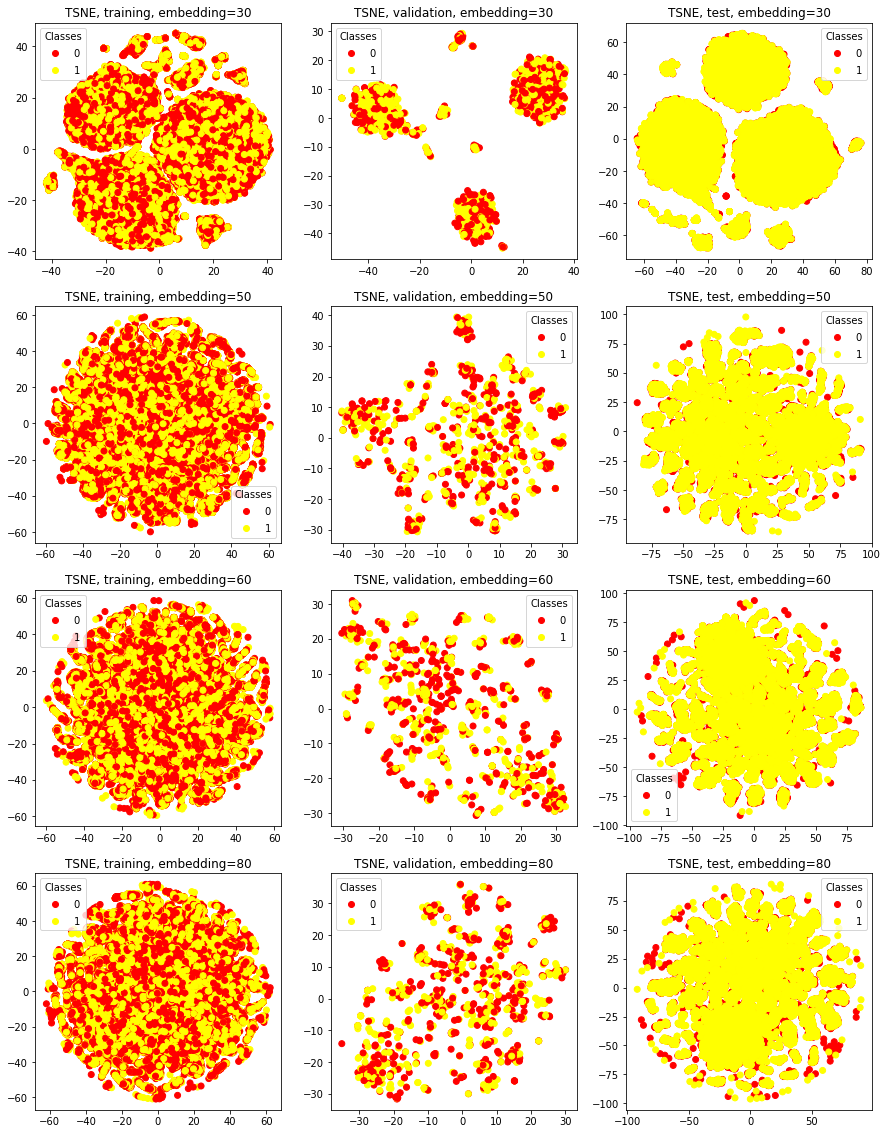

In [17]:
embed_size_list = [30,50,60,80]
num_model = len(embed_size_list)
model_list, hist_list = doc2vec_training(embed_size_list=embed_size_list)

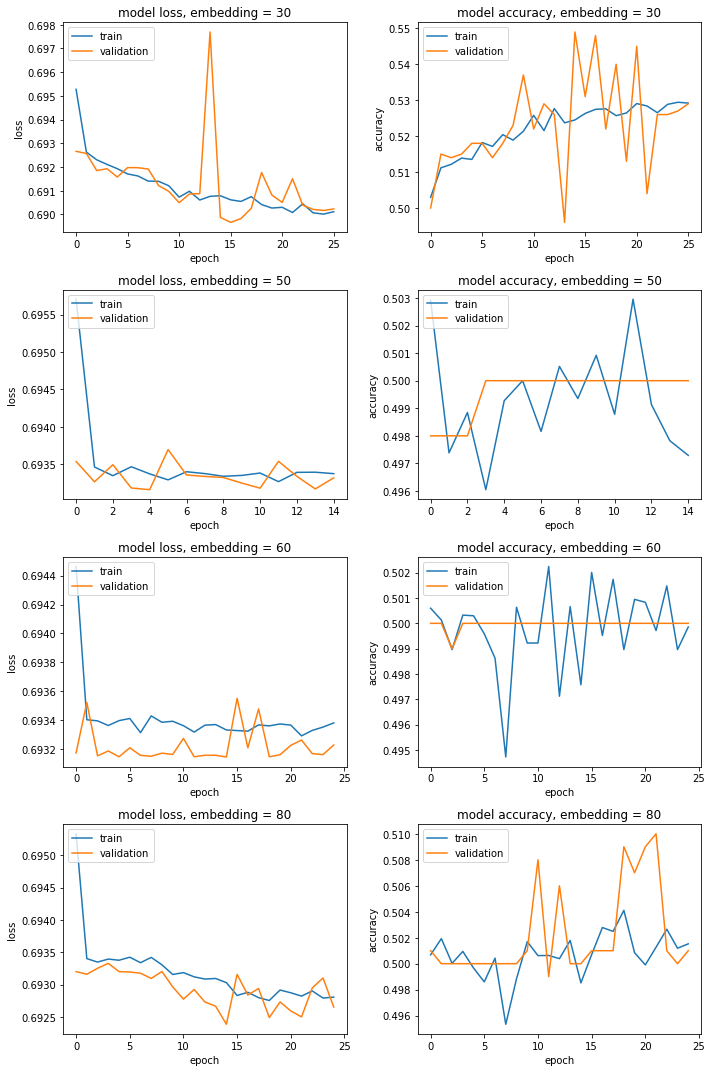

In [19]:
fig, axes = plt.subplots(num_model, 2, figsize=(10, 15))
for i in range(num_model):
  hist = hist_list[i]
  ax1 = axes[i, 0]
  ax2 = axes[i, 1]

  ax1.plot(hist.history['loss'], label='training')
  ax1.plot(hist.history['val_loss'], label='validation')
  ax1.set_title('model loss, embedding = '+str(embed_size_list[i]))
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(hist.history['accuracy'], label='training')
  ax2.plot(hist.history['val_accuracy'], label='validation')
  ax2.set_title('model accuracy, embedding = '+str(embed_size_list[i]))
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()